# 📰 Treinamento de uma rede neural recorrente (RNN) para classificar um conjunto de dados sobre notícias

## 📚 Importação as bibliotecas

In [1]:
import nltk
import torch
import datasets
import numpy as np
from torch import nn
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 🔋 Carregamento dos dados

In [2]:
dataset = datasets.load_dataset("okite97/news-data")
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 828
    })
})

## 🪮 Pré-processamento
**Conversão dos Rótulos:** Cada categoria de notícia é mapeada para um número inteiro, facilitando o treinamento do modelo de classificação.

In [3]:
categories = sorted(list(set(dataset['train']['Category'])))

# Cria o mapeamento: cada categoria é associada a um número
cat2id = {cat: i for i, cat in enumerate(categories)}
id2cat = {i: cat for cat, i in cat2id.items()}

def convert_label(example):
    example['label'] = cat2id[example['Category']]
    return example

dataset = dataset.map(convert_label)

In [4]:
def split_tokens(row):
    row['tokens'] = word_tokenize(row['Excerpt'].lower())
    return row
dataset = dataset.map(split_tokens)
print("Tokens do 1º exemplo:", dataset['train'][0]['tokens'])

Tokens do 1º exemplo: ['uefa', 'has', 'opened', 'disciplinary', 'proceedings', 'against', 'barcelona', ',', 'juventus', 'and', 'real', 'madrid', 'over', 'their', 'involvement', 'in', 'the', 'proposed', 'european', 'super', 'league', '.']


In [5]:
all_tokens = []

for tokens in dataset['train']['tokens']:
  all_tokens.extend(tokens)
print("Total de tokens (train):", len(all_tokens))

Total de tokens (train): 103711


In [6]:
counts = Counter(all_tokens)
counts.most_common(10)

[('the', 6168),
 (',', 3620),
 ('of', 3071),
 ('to', 2280),
 ('a', 2124),
 ('in', 1883),
 ('has', 1688),
 ('on', 1544),
 ('and', 1368),
 ('(', 1011)]

In [7]:
vocab = [token for token, count in counts.items() if count >= 3]
vocab = ['<unk>'] + vocab
print("Amostra do vocabulário:", list(enumerate(vocab[:10])))

Amostra do vocabulário: [(0, '<unk>'), (1, 'uefa'), (2, 'has'), (3, 'opened'), (4, 'proceedings'), (5, 'against'), (6, 'barcelona'), (7, ','), (8, 'juventus'), (9, 'and')]


In [8]:
token2id = {token: idx for idx, token in enumerate(vocab)}

In [9]:
def convert_tokens(tokens):
  result = []
  for token in tokens:
    result.append(token2id.get(token, 0))

  return result

In [10]:
def tokens2ids(row):
  row['tokens_id'] = convert_tokens(row['tokens'])
  return row

In [11]:
dataset['train'] = dataset['train'].map(tokens2ids)
dataset['test'] = dataset['test'].map(tokens2ids)
print("Tokens convertidos para IDs (1º exemplo):", dataset['train'][0]['tokens_id'])

Tokens convertidos para IDs (1º exemplo): [1, 2, 3, 0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


## 🧱 Criação do Dataset Personalizado

A classe `NewsDataset` herda é responsável por retornar os dados (tokens convertidos para IDs) e os rótulos correspondentes. Em seguida, utilizamos o `DataLoader` para embaralhar e agrupar os dados durante o treinamento.

In [12]:
class NewsDataset(Dataset):
  def __init__(self, dataset):
    self.data = dataset['tokens_id']
    self.labels = dataset['label']

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

In [13]:
train_dataset = NewsDataset(dataset['train'])
len(train_dataset)

4686

In [14]:
dataloader = DataLoader(train_dataset, shuffle=True)

## 🏛️ Arquitetura do Modelo

Utilização de RNN composta por:

- **Camada de Embedding:** Converte IDs de tokens em vetores densos de tamanho 128.
- **RNN:** Uma rede com 2 camadas e 32 unidades ocultas.
- **Camada Linear:** Mapeia a última saída da RNN para as 6 classes de notícias.


In [15]:
N_LAYERS = 2
EMBED_LEN = 128
HIDDEN_DIM = 32
NUM_CLASSES = len(set(dataset['train']['Category']))  # Número de categorias: 'business', 'entertainment', 'health', 'politics', 'sports', 'tech'

class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.linear = nn.Linear(HIDDEN_DIM, NUM_CLASSES)

  def forward(self, input):
    embeddings = self.embedding_layer(input)
    output, final_hidden = self.rnn(embeddings)

    return self.linear(final_hidden[-1])

## 👩🏼‍🏫 Treinamento e Avaliação

Durante o treinamento, a função de perda é calculada para cada batch e os gradientes são atualizados utilizando o otimizador Adam. Após cada época, o modelo é avaliado no conjunto de teste, onde também calculamos a acurácia. Os resultados são plotados para análise do desempenho ao longo das épocas.

In [16]:
model = TextClassifier()

LR = 1e-3
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TextClassifier(
  (embedding_layer): Embedding(4094, 128)
  (rnn): RNN(128, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=6, bias=True)
)

In [18]:
def train(dataloader):
  size = len(dataloader.dataset)
  train_loss = []

  for batch, (data, label) in enumerate(tqdm(dataloader)):
    data, label = data.to(device), label.to(device)
    optimizer.zero_grad()
    
    out = model(data)
    
    loss = loss_fn(out, label)
    train_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()

    if batch % 1000 == 0:
      loss_val, current = loss.item(), batch * len(data)
      print(f' loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]')

  return train_loss

In [19]:
def test(dataloader):
  size = len(dataloader.dataset)
  test_loss = []
  correct = 0

  with torch.no_grad():
    for data, label in tqdm(dataloader):
      data, label = data.to(device), label.to(device)
      out = model(data)

      loss = loss_fn(out, label)
      test_loss.append(loss.item())

      preds = torch.argmax(out, dim=1)
      correct += (preds == label).sum().item()
      
  accuracy = correct / size
  print(f' test accuracy: {(100*accuracy):>0.1f}%, test loss: {test_loss[-1]:>8f} ')

  return test_loss

In [20]:
test_dataset = NewsDataset(dataset['test'])
dataloader_test = DataLoader(test_dataset, shuffle=True)

In [21]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1} -------------------------------')

    print('Train')
    train_losses.append(train(dataloader))

    print('Test')
    test_losses.append(test(dataloader_test))

Epoch 1 -------------------------------
Train


  0%|          | 1/4686 [00:00<08:52,  8.79it/s]

 loss: 2.132905  [    0/ 4686]


 22%|██▏       | 1012/4686 [00:11<01:17, 47.14it/s]

 loss: 1.340491  [ 1000/ 4686]


 43%|████▎     | 2009/4686 [00:26<00:41, 64.11it/s]

 loss: 1.482255  [ 2000/ 4686]


 64%|██████▍   | 3010/4686 [00:45<00:25, 66.69it/s]

 loss: 1.124005  [ 3000/ 4686]


 86%|████████▌ | 4010/4686 [01:04<00:11, 58.34it/s]

 loss: 1.064018  [ 4000/ 4686]


100%|██████████| 4686/4686 [01:16<00:00, 61.45it/s]


Test


100%|██████████| 828/828 [00:01<00:00, 614.21it/s]


 test accuracy: 41.2%, test loss: 0.516168 
Epoch 2 -------------------------------
Train


  0%|          | 6/4686 [00:00<01:29, 52.43it/s]

 loss: 2.359738  [    0/ 4686]


 22%|██▏       | 1011/4686 [00:17<01:51, 33.07it/s]

 loss: 0.612372  [ 1000/ 4686]


 43%|████▎     | 2005/4686 [00:34<00:51, 51.57it/s]

 loss: 1.097106  [ 2000/ 4686]


 64%|██████▍   | 3014/4686 [00:50<00:19, 85.38it/s] 

 loss: 1.175413  [ 3000/ 4686]


 86%|████████▌ | 4010/4686 [01:02<00:07, 87.61it/s]

 loss: 1.437519  [ 4000/ 4686]


100%|██████████| 4686/4686 [01:11<00:00, 65.69it/s]


Test


100%|██████████| 828/828 [00:00<00:00, 1058.00it/s]


 test accuracy: 46.9%, test loss: 0.443107 
Epoch 3 -------------------------------
Train


  0%|          | 10/4686 [00:00<00:49, 94.24it/s]

 loss: 0.124789  [    0/ 4686]


 22%|██▏       | 1010/4686 [00:12<00:44, 81.85it/s]

 loss: 0.866019  [ 1000/ 4686]


 43%|████▎     | 2015/4686 [00:24<00:30, 88.27it/s]

 loss: 0.115951  [ 2000/ 4686]


 64%|██████▍   | 3010/4686 [00:36<00:21, 78.14it/s]

 loss: 0.697177  [ 3000/ 4686]


 86%|████████▌ | 4008/4686 [00:48<00:08, 83.39it/s]

 loss: 1.995893  [ 4000/ 4686]


100%|██████████| 4686/4686 [00:56<00:00, 83.17it/s]


Test


100%|██████████| 828/828 [00:00<00:00, 1112.65it/s]


 test accuracy: 55.2%, test loss: 0.171092 
Epoch 4 -------------------------------
Train


  0%|          | 14/4686 [00:00<00:35, 132.86it/s]

 loss: 1.880299  [    0/ 4686]


 22%|██▏       | 1009/4686 [00:12<00:46, 78.78it/s]

 loss: 2.175457  [ 1000/ 4686]


 43%|████▎     | 2009/4686 [00:24<00:30, 86.94it/s]

 loss: 1.246150  [ 2000/ 4686]


 64%|██████▍   | 3013/4686 [00:36<00:20, 82.48it/s]

 loss: 2.047312  [ 3000/ 4686]


 86%|████████▌ | 4014/4686 [00:49<00:08, 82.95it/s]

 loss: 2.542472  [ 4000/ 4686]


100%|██████████| 4686/4686 [00:57<00:00, 81.75it/s]


Test


100%|██████████| 828/828 [00:00<00:00, 1015.04it/s]


 test accuracy: 61.1%, test loss: 3.174726 
Epoch 5 -------------------------------
Train


  0%|          | 9/4686 [00:00<00:56, 82.44it/s]

 loss: 1.886587  [    0/ 4686]


 22%|██▏       | 1017/4686 [00:12<00:44, 82.07it/s]

 loss: 1.225087  [ 1000/ 4686]


 43%|████▎     | 2019/4686 [00:24<00:26, 100.66it/s]

 loss: 1.565302  [ 2000/ 4686]


 64%|██████▍   | 3015/4686 [00:37<00:17, 92.96it/s] 

 loss: 0.192485  [ 3000/ 4686]


 86%|████████▌ | 4009/4686 [00:50<00:07, 91.85it/s]

 loss: 0.595828  [ 4000/ 4686]


100%|██████████| 4686/4686 [00:58<00:00, 79.59it/s]


Test


100%|██████████| 828/828 [00:00<00:00, 992.95it/s] 


 test accuracy: 62.9%, test loss: 2.666622 


In [22]:
epoch_train_loss = [np.mean(losses) for losses in train_losses]
epoch_test_loss = [np.mean(losses) for losses in test_losses]

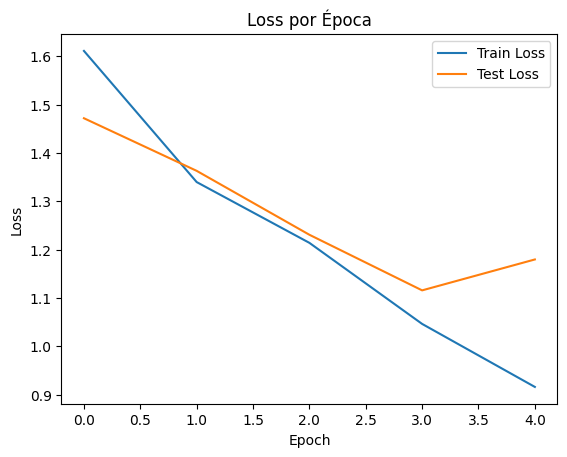

In [23]:
plt.plot(epoch_train_loss, label='Train Loss')
plt.plot(epoch_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss por Época')
plt.legend()
plt.show()